# ResNET

## Theory

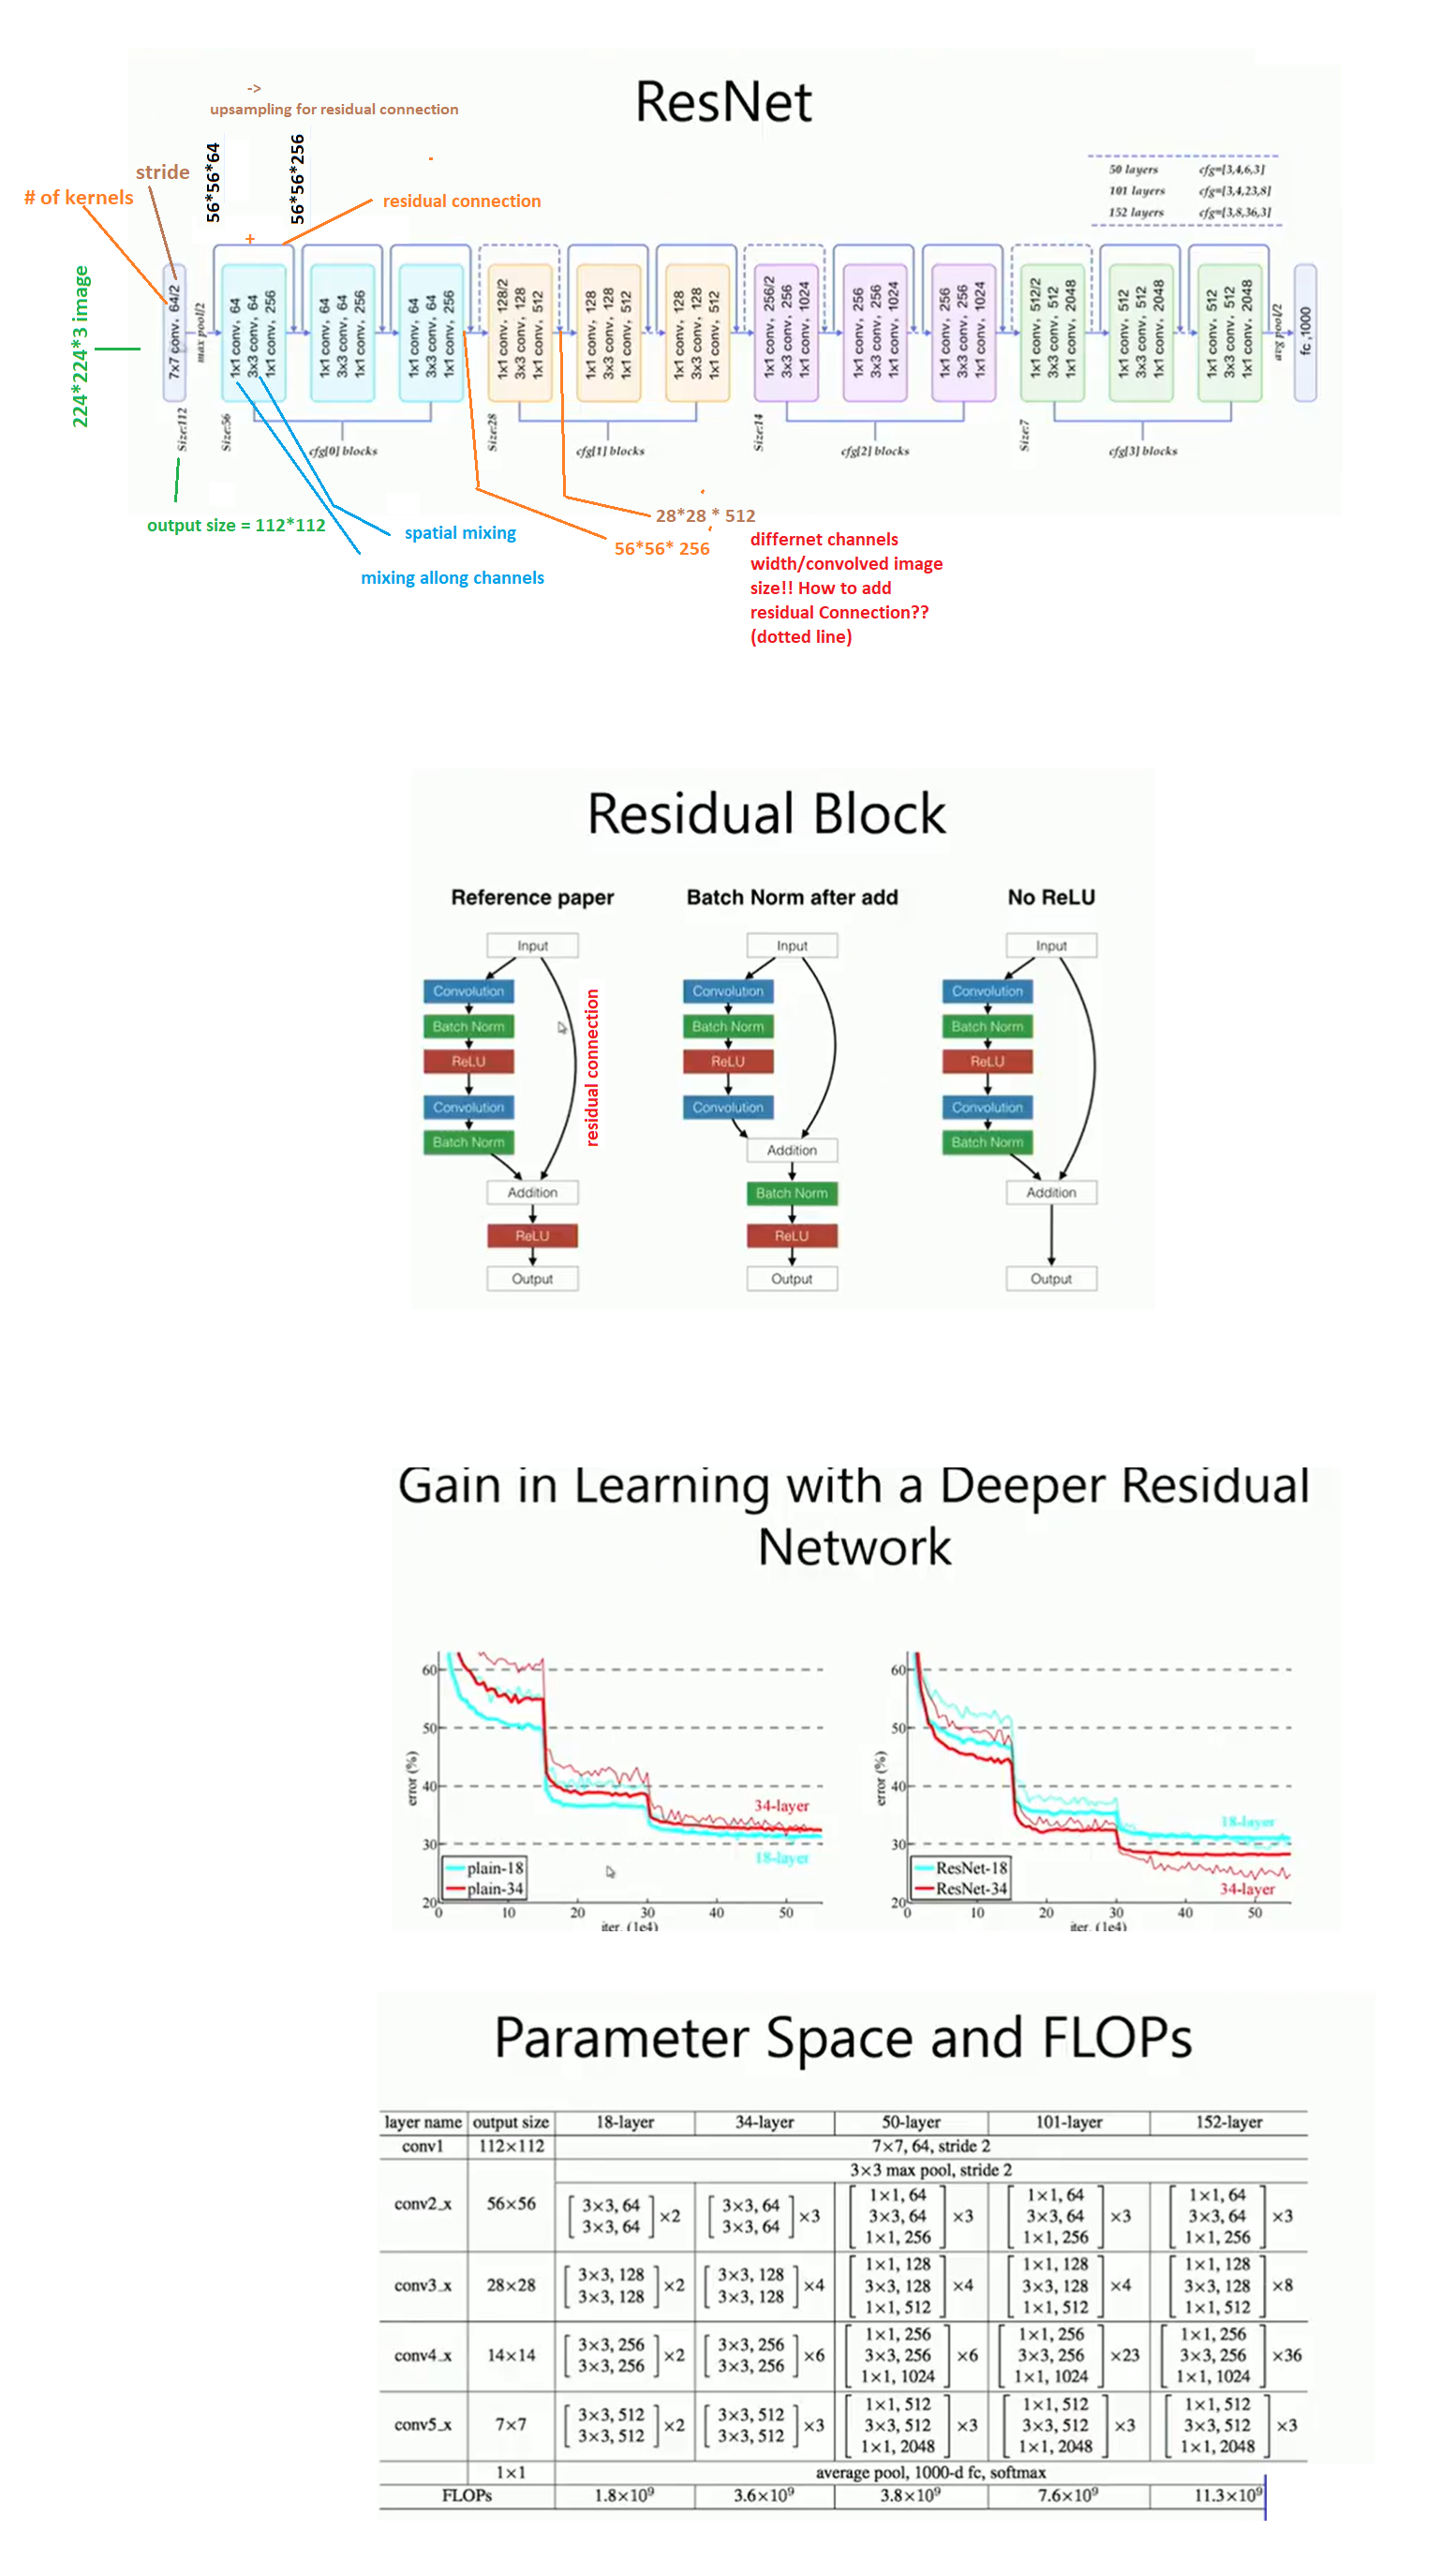

## Imports

In [1]:
%matplotlib inline
import copy
import time
import tqdm
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms,datasets, models

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


## Load Data:

In [2]:
apply_transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
BatchSize = 1

trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 50000
No. of samples in test set: 10000


## Define network architecture

In [4]:
net = models.resnet18()
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Counting number of trainable parameters
totalParams = 0
for name,params in net.named_parameters():
    print(name,'-->',params.size())
    totalParams += np.sum(np.prod(params.size()))
print('Total number of parameters: '+str(totalParams))

conv1.weight --> torch.Size([64, 3, 7, 7])
bn1.weight --> torch.Size([64])
bn1.bias --> torch.Size([64])
layer1.0.conv1.weight --> torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight --> torch.Size([64])
layer1.0.bn1.bias --> torch.Size([64])
layer1.0.conv2.weight --> torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight --> torch.Size([64])
layer1.0.bn2.bias --> torch.Size([64])
layer1.1.conv1.weight --> torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight --> torch.Size([64])
layer1.1.bn1.bias --> torch.Size([64])
layer1.1.conv2.weight --> torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight --> torch.Size([64])
layer1.1.bn2.bias --> torch.Size([64])
layer2.0.conv1.weight --> torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight --> torch.Size([128])
layer2.0.bn1.bias --> torch.Size([128])
layer2.0.conv2.weight --> torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight --> torch.Size([128])
layer2.0.bn2.bias --> torch.Size([128])
layer2.0.downsample.0.weight --> torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight 

In [6]:
# Modifying the last fully-connected layer for 10 classes
net.fc = nn.Linear(512,10)

In [7]:
# Copying initial weights for visualization
init_weightConv1 = copy.deepcopy(net.conv1.weight.data) # 1st conv layer
init_weightConv2 = copy.deepcopy(net.layer1[0].conv1.weight.data) # 2nd conv layer

In [8]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"
    
net = net.to(device)

GPU is available!


## Resnet from SCRATCH

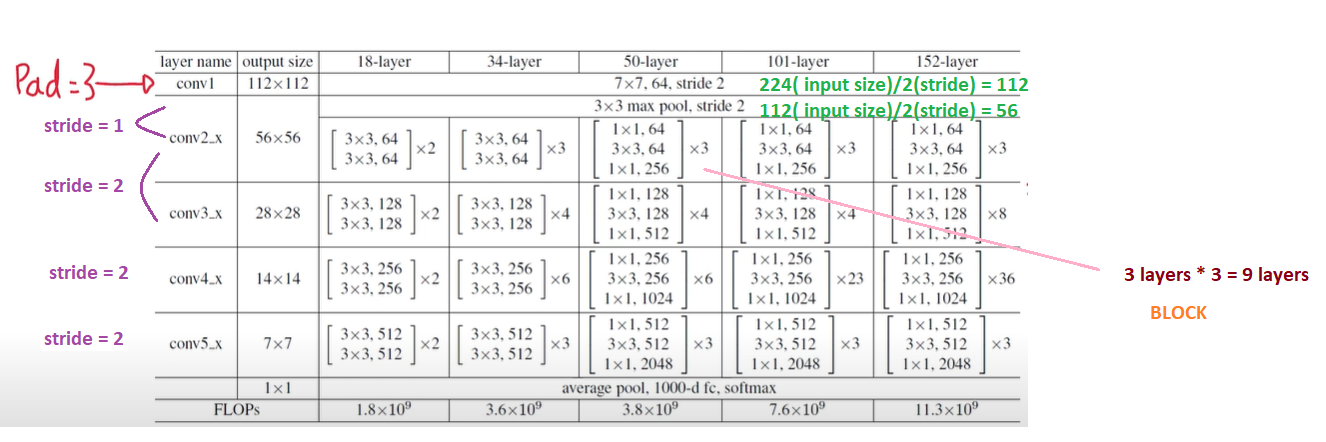

RESNET uses blocks multiple times. <br>
Thus cretae a class for these blocks

In [13]:
import torch
import torch.nn as nn

In [ ]:
class block(nn.Module):
    """class for the repeating blocks in ResNet Architecture"""
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):  ###identity_sownsample = adapting the identity in case of change in size
        
        super(block, self).__init__()
        self.expansion = 4
#since number of output channels in a block is 4 times the inpout channels in a block
#eg: 1st block 64 -> 64 -> 256 , thus 4 times increase
        
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

ResNET 50 <br>
- 1st blcok is resued 3 times
- 2nb block is reused 4 times
- 3rd block is used 6 times
- 4th blovck is used 3 times
 - [3,4,6,3]

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        # block = block class previoulsy created
        # layers = list tells us how many times to use blocks eg: [3,4,6,3]
        # img_channels = RGB (3)
        
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [ ]:
def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)

In [ ]:
def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)

In [ ]:
def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())
    
test()

## Define loss function and optimizer

In [ ]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam

## Train the network

In [ ]:
iterations = 10
trainLoss = []
trainAuxLoss = []
trainTotalLoss = []
trainAcc = []

testLoss = []
testAcc = []

start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0.0   
    avgTotalLoss = 0.0
    running_correct = 0
    net.train() # For training
    for data in tqdm.tqdm_notebook(trainLoader):
        # Initialize gradients to zero
        optimizer.zero_grad()
        
        inputs,labels = data        
        inputs, labels = inputs.to(device), labels.to(device)  
        # Feed-forward input data through the network        
        outputs = net(inputs) 
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels.data).sum()          
               
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()  
              
    avgTrainAcc = 100*float(running_correct)/50000.0
    avgTrainLoss = runningLoss/(50000.0  /BatchSize)  
    trainAcc.append(avgTrainAcc)
    trainLoss.append(avgTrainLoss)    
    
    # Evaluating performance on test set for each epoch
    net.eval() # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    with torch.no_grad():
        for data in testLoader:
            inputs,labels = data            
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels.data).sum()

            loss = criterion(F.log_softmax(outputs,dim=1), labels)
            runningLoss += loss.item()  
            
            
            
    avgTestLoss = runningLoss/(10000.0/BatchSize)
    avgTestAcc = 100*float(running_correct)/10000.0
    testLoss.append(avgTestLoss)
    testAcc.append(avgTestAcc)
        
    
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')  
    plt.plot(range(epoch+1),testLoss,'g-',label='test') 
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),trainAcc,'r-',label='train')    
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))


In [ ]:
# Copying trained weights for visualization
trained_weightConv1 = copy.deepcopy(net.conv1.weight.data)
trained_weightConv2 = copy.deepcopy(net.layer1[0].conv1.weight.data)
if use_gpu:
    trained_weightConv1 = trained_weightConv1.cpu()
    trained_weightConv2 = trained_weightConv2.cpu()

## Visualization of weights

In [ ]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
# Visualizing weights of 1st convolutional layer
imshow(torchvision.utils.make_grid(init_weightConv1,nrow=8,normalize=True),'Initial weights: conv1')
imshow(torchvision.utils.make_grid(trained_weightConv1,nrow=8,normalize=True),'Trained weights: conv1')
imshow(torchvision.utils.make_grid(init_weightConv1-trained_weightConv1,nrow=8,normalize=True),'Difference of weights: conv1')

In [ ]:
# Visualizing weights of 2nd convolutional layer
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Initial weights: conv2')
imshow(torchvision.utils.make_grid(trained_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Trained weights: conv2')
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1)-trained_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Difference of weights: conv2')

In [ ]:
# Lecture 39: ResNet

%matplotlib inline
import copy
import time
import tqdm
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms,datasets, models

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

## Load Data:

apply_transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
BatchSize = 1

trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

## Define network architecture

net = models.resnet18()
print(net)

# Counting number of trainable parameters
totalParams = 0
for name,params in net.named_parameters():
    print(name,'-->',params.size())
    totalParams += np.sum(np.prod(params.size()))
print('Total number of parameters: '+str(totalParams))

# Modifying the last fully-connected layer for 10 classes
net.fc = nn.Linear(512,10)

# Copying initial weights for visualization
init_weightConv1 = copy.deepcopy(net.conv1.weight.data) # 1st conv layer
init_weightConv2 = copy.deepcopy(net.layer1[0].conv1.weight.data) # 2nd conv layer

# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"
    
net = net.to(device)

## Define loss function and optimizer

criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam

## Train the network

iterations = 10
trainLoss = []
trainAuxLoss = []
trainTotalLoss = []
trainAcc = []

testLoss = []
testAcc = []

start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0.0   
    avgTotalLoss = 0.0
    running_correct = 0
    net.train() # For training
    for data in tqdm.tqdm_notebook(trainLoader):
        # Initialize gradients to zero
        optimizer.zero_grad()
        
        inputs,labels = data        
        inputs, labels = inputs.to(device), labels.to(device)  
        # Feed-forward input data through the network        
        outputs = net(inputs) 
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels.data).sum()          
               
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()  
              
    avgTrainAcc = 100*float(running_correct)/50000.0
    avgTrainLoss = runningLoss/(50000.0  /BatchSize)  
    trainAcc.append(avgTrainAcc)
    trainLoss.append(avgTrainLoss)    
    
    # Evaluating performance on test set for each epoch
    net.eval() # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    with torch.no_grad():
        for data in testLoader:
            inputs,labels = data            
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels.data).sum()

            loss = criterion(F.log_softmax(outputs,dim=1), labels)
            runningLoss += loss.item()  
            
            
            
    avgTestLoss = runningLoss/(10000.0/BatchSize)
    avgTestAcc = 100*float(running_correct)/10000.0
    testLoss.append(avgTestLoss)
    testAcc.append(avgTestAcc)
        
    
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')  
    plt.plot(range(epoch+1),testLoss,'g-',label='test') 
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),trainAcc,'r-',label='train')    
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))


# Copying trained weights for visualization
trained_weightConv1 = copy.deepcopy(net.conv1.weight.data)
trained_weightConv2 = copy.deepcopy(net.layer1[0].conv1.weight.data)
if use_gpu:
    trained_weightConv1 = trained_weightConv1.cpu()
    trained_weightConv2 = trained_weightConv2.cpu()

## Visualization of weights

# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Visualizing weights of 1st convolutional layer
imshow(torchvision.utils.make_grid(init_weightConv1,nrow=8,normalize=True),'Initial weights: conv1')
imshow(torchvision.utils.make_grid(trained_weightConv1,nrow=8,normalize=True),'Trained weights: conv1')
imshow(torchvision.utils.make_grid(init_weightConv1-trained_weightConv1,nrow=8,normalize=True),'Difference of weights: conv1')

# Visualizing weights of 2nd convolutional layer
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Initial weights: conv2')
imshow(torchvision.utils.make_grid(trained_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Trained weights: conv2')
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1)-trained_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Difference of weights: conv2')

# DenseNet

## Intro

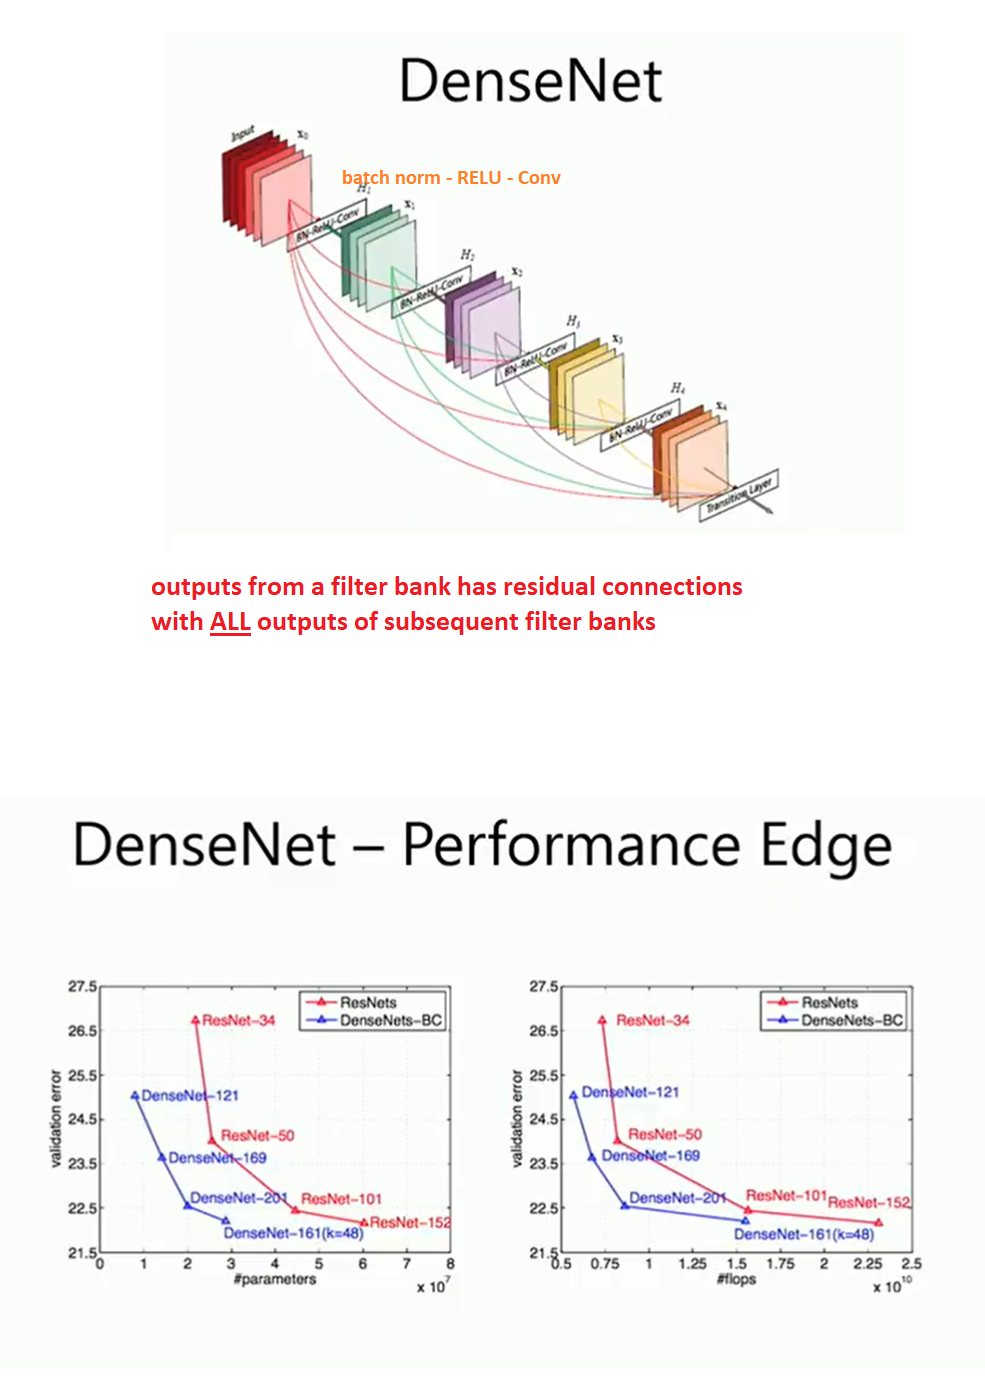

## Import

In [15]:
%matplotlib inline
import copy
import time
import tqdm
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms,datasets, models

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


## Load Data:

In [16]:
apply_transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
BatchSize = 1

trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 50000
No. of samples in test set: 10000


## Define network architecture

In [11]:
net = models.densenet121()
print(net)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
# Counting number of trainable parameters
totalParams = 0
for name,params in net.named_parameters():
    print(name,'-->',params.size())
    totalParams += np.sum(np.prod(params.size()))
print('Total number of parameters: '+str(totalParams))

features.conv0.weight --> torch.Size([64, 3, 7, 7])
features.norm0.weight --> torch.Size([64])
features.norm0.bias --> torch.Size([64])
features.denseblock1.denselayer1.norm1.weight --> torch.Size([64])
features.denseblock1.denselayer1.norm1.bias --> torch.Size([64])
features.denseblock1.denselayer1.conv1.weight --> torch.Size([128, 64, 1, 1])
features.denseblock1.denselayer1.norm2.weight --> torch.Size([128])
features.denseblock1.denselayer1.norm2.bias --> torch.Size([128])
features.denseblock1.denselayer1.conv2.weight --> torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer2.norm1.weight --> torch.Size([96])
features.denseblock1.denselayer2.norm1.bias --> torch.Size([96])
features.denseblock1.denselayer2.conv1.weight --> torch.Size([128, 96, 1, 1])
features.denseblock1.denselayer2.norm2.weight --> torch.Size([128])
features.denseblock1.denselayer2.norm2.bias --> torch.Size([128])
features.denseblock1.denselayer2.conv2.weight --> torch.Size([32, 128, 3, 3])
features.denseblock1

In [ ]:
# Modifying the last fully-connected layer for 10 classes
net.classifier = nn.Linear(1024,10)

In [ ]:
# Copying initial weights for visualization
init_weightConv1 = copy.deepcopy(net.features.conv0.weight.data) # 1st conv layer
init_weightConv2 = copy.deepcopy(net.features.denseblock1.denselayer1[2].weight.data) # 2nd conv layer

In [ ]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"
    
net = net.to(device)

## Define loss function and optimizer

In [ ]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam

## Train the network

In [ ]:
iterations = 10
trainLoss = []
trainAuxLoss = []
trainTotalLoss = []
trainAcc = []

testLoss = []
testAcc = []

start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0.0   
    avgTotalLoss = 0.0
    running_correct = 0
    net.train() # For training
    for data in tqdm.tqdm_notebook(trainLoader):
        # Initialize gradients to zero
        optimizer.zero_grad()
        
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Feed-forward input data through the network        
        outputs = net(inputs) 
        _, predicted = torch.max(outputs.data, 1)  
        running_correct += (predicted == labels.data).sum()           
               
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()    
        
        
    avgTrainAcc = 100*float(running_correct)/50000.0
    avgTrainLoss = runningLoss/(50000.0/BatchSize)    
    trainAcc.append(avgTrainAcc)
    trainLoss.append(avgTrainLoss)    
    
    # Evaluating performance on test set for each epoch
    net.eval() # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    with torch.no_grad():
        for data in testLoader:
            inputs,labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels.data).sum()   
            loss = criterion(F.log_softmax(outputs,dim=1), labels)
            runningLoss += loss.item()   
        
            
    avgTestLoss = runningLoss/(10000.0/BatchSize)
    avgTestAcc = 100*float(running_correct)/10000.0
    testLoss.append(avgTestLoss)
    testAcc.append(avgTestAcc)
        
    
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')  
    plt.plot(range(epoch+1),testLoss,'g-',label='test') 
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),trainAcc,'r-',label='train')    
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))


In [ ]:
# Copying trained weights for visualization
trained_weightConv1 = copy.deepcopy(net.features.conv0.weight.data)
trained_weightConv2 = copy.deepcopy(net.features.denseblock1.denselayer1[2].weight.data)
if use_gpu:
    trained_weightConv1 = trained_weightConv1.cpu()
    trained_weightConv2 = trained_weightConv2.cpu()

## Visualization of weights

In [ ]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')

In [ ]:
# Visualizing weights of 1st convolutional layer
imshow(torchvision.utils.make_grid(init_weightConv1,nrow=8,normalize=True),'Initial weights: conv1')
imshow(torchvision.utils.make_grid(trained_weightConv1,nrow=8,normalize=True),'Trained weights: conv1')
imshow(torchvision.utils.make_grid(init_weightConv1-trained_weightConv1,nrow=8,normalize=True),'Difference of weights: conv1')

In [ ]:
# Visualizing weights of 2nd convolutional layer
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Initial weights: conv2')
imshow(torchvision.utils.make_grid(trained_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Trained weights: conv2')
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1)-trained_weightConv2[0].unsqueeze(1),nrow=8,normalize=True),'Difference of weights: conv2')